## This will be the final version of the thesis in a jupyter notebook. 

Seperate out crude aspects of data wrangling into a seperate class file

### Overview of the data and its attributes-  Normalization with respect to bit rate, bit depth, length of recording, number of channels

The urban sound 8k dataset is a collection of annotated audio clips which can be used to develop applications for classifying sounds. It contains 8,732 labelled sound clips (4 seconds each) from ten classes: air conditioner, car horn, children playing, dog bark, drilling, engine idling, gunshot, jackhammer, siren, and street music. The dataset by default is divided into 10-folds for cross validation. Merging the annotated chimpanzee clips with this dataset will allow us to build a classifier that can discriminatively classify chimpanzee sounds as well :)

The LibROSA package is central to the development of our model. It provides us with powerful tools for visualization, information retrieval and feature extraction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import struct
import librosa
import librosa.display
from scipy.io import wavfile as wav
import IPython.display as ipd
import gammatone
import feature_utils
import pickle
import timeit

In [2]:
data = pd.read_csv("D:/Thesis/UrbanSound8K/metadata/UrbanSound8K.csv")
data.shape

(8732, 8)

In [3]:
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


The meta-data contains 8 columns:

- slice_file_name: name of the audio file
- fsID: FreesoundID of the recording where the excerpt is taken from
- start: start time of the clip
- end: end time of the clip
- salience: salience rating of the sound. 1 = foreground, 2 = background
- fold: The fold number (1–10) to which this file has been allocated
- classID:
    0 = air_conditioner
    1 = car_horn
    2 = children_playing
    3 = dog_bark
    4 = drilling
    5 = engine_idling
    6 = gun_shot
    7 = jackhammer
    8 = siren
    9 = street_music
- class: class name

The audio data has been already sliced and excerpted and even allocated to 10 different folds. Some of the excerpts are from the same original file but different slice. If one slice from a certain recording was in training data, and a different slice from the same recording was in test data, this might increase the accuracy of a final model falsely. But this has been taken care of by allocating slices into folds such that all slices originating from the same Freesound recording go into the same fold.

Now let’s take a look at the class distribution of each fold to see how balanced the dataset is.

In [4]:
appended = []
for i in range(1,11):
    appended.append(data[data.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

,index,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,fold1,100,36,100,100,100,96,35,120,86,100
1,fold2,100,42,100,100,100,100,35,120,91,100
2,fold3,100,43,100,100,100,107,36,120,119,100
3,fold4,100,59,100,100,100,107,38,120,166,100
4,fold5,100,98,100,100,100,107,40,120,71,100
5,fold6,100,28,100,100,100,107,46,68,74,100
6,fold7,100,28,100,100,100,106,51,76,77,100
7,fold8,100,30,100,100,100,88,30,78,80,100
8,fold9,100,32,100,100,100,89,31,82,82,100
9,fold10,100,33,100,100,100,93,32,96,83,100


In [5]:
data['class'].value_counts(normalize=False)

engine_idling       1000
children_playing    1000
drilling            1000
dog_bark            1000
jackhammer          1000
air_conditioner     1000
street_music        1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

The dataset is relatively balanced with lesser frequencies of car_horn and gun_shot(s). We will investigate whether to drop the classes with low value counts or choose to perform augmentation on them if the classifier is not robust enough.

Apart from value counts, there are other parameters to normalize: sampling rate, bit depth and number of channels. Before we can reliably use the dataset for training our classifier, there must be a parameter consistency between the Urbansound8K dataset and the chimp calls that we are going to append to this dataset.

In [6]:
from scipy.io import wavfile as wav
import IPython.display as ipd

def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('D:/Thesis/UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('number of channels: ',wav_sample.shape)
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

We will now see the information contained in a single soundfile.

sampling rate:  44100 Hz
bit depth:  16
duration:  4.0  second
number of samples:  176400
number of channels:  (176400, 2)
class:  car_horn


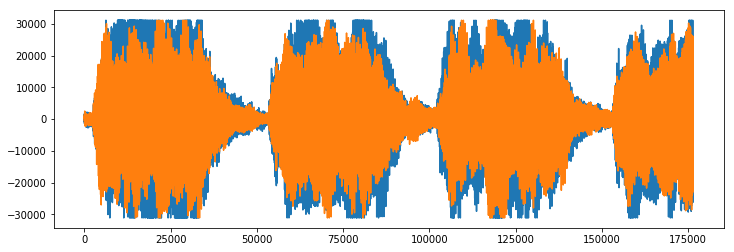

In [7]:
fullpath, label = path_class('9674-1-0-1.wav')
wav_plotter(fullpath,label)

We need to normalize the audio parameters of Urbansound8 dataset to that of what is recieved in our sensors. Constraints imposed in the favour of effective memory management. Let us see an example of a human labelled chimp call record.

sampling rate:  11025 Hz
bit depth:  16
duration:  10.652426303854876  second
number of samples:  117443
number of channels:  (117443,)
class:  chimp


d:\python36\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


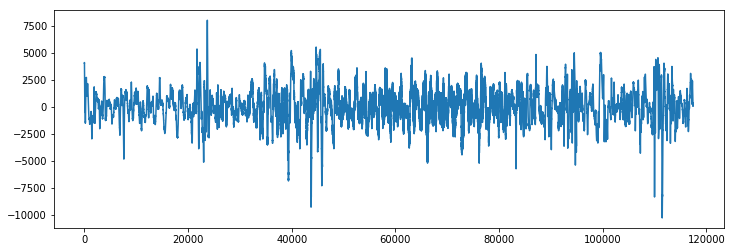

In [8]:
chimp_ex1 = 'D:\Thesis\Collated\examples\chimp2.wav'
wav_plotter(chimp_ex1,'chimp')

In [9]:
def wav_fmt_parser(file_name):
    full_path, _ = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

In [10]:
wav_fmt_data = [wav_fmt_parser(i) for i in data.slice_file_name]

In [11]:
data[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,n_channels,sampling_rate,bit_depth
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,2,44100,16
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,2,44100,16
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,2,44100,16
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,2,44100,16
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,2,44100,16


In [12]:
data.sampling_rate.value_counts()

44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: sampling_rate, dtype: int64

We can see that the sample rates are not consistent and need to be normalized to a value which can still allow us to perform sound classification tasks. The chimp calls recorded have a sampling rate of 11025hz. Therefore, I have chosen a value of 11025 to which all the sounds can downsampled.

In [13]:
data.n_channels.value_counts()

2    7993
1     739
Name: n_channels, dtype: int64

Also, since the chimp audio files are recorded in mono, It is necessary to change the number of channels to 1 for all the files before training.

In [14]:
data.bit_depth.value_counts()

16    5758
24    2753
32     169
8       43
4        9
Name: bit_depth, dtype: int64

### Normalize and arrange into respective folders, add chimps folder 

The chimp audio files have a bit depth of 16. We will normalize all the files to 16 bit to avoid any loss of information and consistency. Also, by arranging the sound files by class makes it easier to drag and drop the chimp recordings directory rahter than sorting them into folds.

In [15]:
def create_directory(dirname):
    """Check directory exists or create it."""
    if not os.path.exists(dirname):
        os.makedirs(dirname)

In [16]:
def convert_urban_to_pcm16():
    """Convert urbansound codec from to PCM_16."""
    src_dir = ['D:/Thesis/UrbanSound8K/audio/fold{:d}'.format(i+1) for i in range(10)]
    dst_dir = ['D:/Thesis/UrbanSound8K-16bit/audio/fold{:d}'.format(i+1) for i in range(10)]
    converted_wav_paths = []
    for dsrc, ddst in zip(src_dir, dst_dir):
        create_directory(ddst)
        wav_files = filter(lambda FP: FP if FP.endswith('.wav') else None, 
                           [FP for FP in os.listdir(dsrc)])
        for wav_file in wav_files:
            src_wav, dst_wav = os.path.join(dsrc, wav_file), os.path.join(ddst, wav_file)
            convert_wav(src_wav, dst_wav, subtype='PCM_16')
            converted_wav_paths.append(dst_wav)
            print('converted count:', len(converted_wav_paths))
    print(converted_wav_paths, len(converted_wav_paths))

In [17]:
def arange_urban_sound_file_by_class():
    """Arange urbansound files by their classes."""
    src_paths = ["D:/Thesis/UrbanSound8K/audio/fold{:d}".format(i+1) for i in range(10)]
    dst_dir = 'D:/Thesis/UrbanSound8K-16bit/audio-classified'
    CLASSES = [
        'air conditioner',
        'car horn',
        'children playing',
        'dog bark',
        'drilling',
        'engine idling',
        'gun shot',
        'jackhammer',
        'siren',
        'street music']
    CLASSES_STRIPED = [c.replace(' ', '_') for c in CLASSES]
    for src in src_paths:
        fold_dir = glob.glob(os.path.join(src, "*.wav"))
        for fn in fold_dir:
            lbl = int(fn.split('\\')[1].split('-')[1])
            dst = '{dir}/{label}'.format(dir=dst_dir, label=CLASSES_STRIPED[lbl])
            create_directory(dst)
            copy_file(fn, '{dst}/{name}'.format(dst=dst, name=fn.split('\\')[-1]))


In [18]:
# convert_urban_to_pcm16()
# arange_urban_sound_file_by_class()
# delete sounds <4 sec

In [5]:
def getListOfFiles(dirpath):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirpath)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirpath, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)        
    
    return allFiles

def urban_labels(Y, fpaths):
    """urban sound dataset labels."""
    urban_label = lambda path: int(os.path.split(path)[-1].split('-')[1])
    for p in fpaths:
        Y = np.append(Y, [urban_label(p)])
    return Y

In [6]:
#path to the converted files
DATASET_16BIT_PATH = "D:/Thesis/UrbanSound8K-16bit/audio-classified"

filepaths = np.asarray(getListOfFiles(DATASET_16BIT_PATH))
print("No of entries in our Dataset: ", filepaths.shape)

Y = np.ndarray(0)
labels = urban_labels(Y, filepaths)
print("Labels : ",labels.shape)

with open("filepaths.txt", "wb") as fp:   #Pickling
    pickle.dump(filepaths, fp)
    
with open("labels.txt", "wb") as fp:   #Pickling
    pickle.dump(labels, fp)

No of entries in our Dataset:  (10303,)
Labels :  (10303,)


### Experiment1 : Features and respective performance. plots

Typically, a signal is divided into smaller frames, often in the range of 10-30 ms and a window function is applied to smooth the signal for further analysis. Depending upon the sampling frequency of the signal, a frame size of 256, 512 or 1024 samples are noormally chosen with some degree of overlap between sucessive frames. This is done to prevent loss of information around the edges of the window. 

MFCCs: Humans are better at differentiating small changes in pitch at low frequencies than at high frequencies. MFCC's equally space the frequency bands on the mel scale which more closely resembles how humans percieve sound when compared to linearly spaced cepstrums. In addition, a cepstrum gives information about how the frequencies change in different spectrum bands. Therefore a combination of mel-scale and cepstrum make MFCCs the widely used feature choice for audio classification applications.

<img src="images/Melscale.png">

In [8]:
def mel_spec(file_paths, n_mels):

    X,sr = librosa.load(file_paths, sr=11025, res_type='kaiser_fast')
    melspec = librosa.feature.melspectrogram(y=X, sr=sr, n_mels=n_mels,fmax=5500)
                               
    return melspec

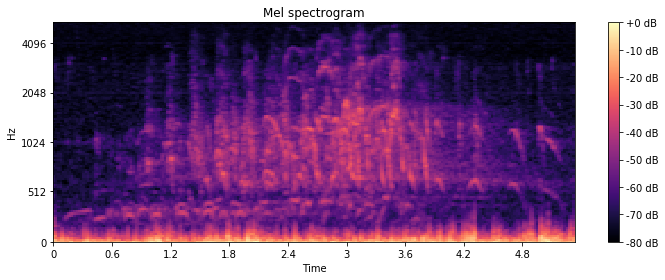

In [9]:
Ms = mel_spec('D:\Thesis\Collated\examples\chimp2.wav',128)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(Ms,ref=np.max),y_axis='mel', fmax=5500,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

GTCCs: Gammatone cepstral coefficients are a more recent addition to the family of cepstral features. GTCCs employ a gammatone filter, a linear filter which models the frequency selectivity property of the human cochlea. GTCCs are being closely followed in speech and non speech recognition applications. Recent studies show that GTCCs are more effective than MFCCs in representing the spectral characteristics of non-speech audio signals, especially at low frequencies.
<img src="images/gtfb.png">

In [10]:
def gammatone_spec(file_paths, n_channels):

    X,sr = librosa.load(file_paths, sr=11025, res_type='kaiser_fast')
    gammaspec = gammatone.gtgram.gtgram(wave = X, fs = sr, window_time = 0.025, hop_time = 0.010, channels = n_channels, f_min = 20)             
                
    return gammaspec

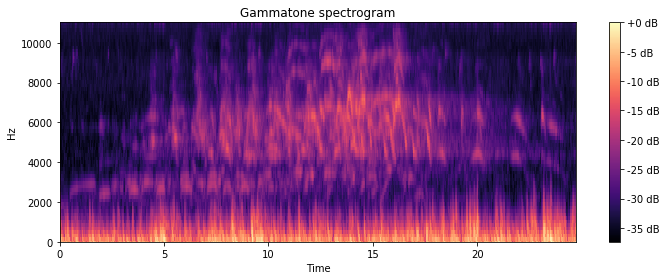

In [11]:
Gs = gammatone_spec('D:\Thesis\Collated\examples\chimp2.wav',64)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(Gs,ref=np.max),y_axis='linear', fmax=5500,x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Gammatone spectrogram')
plt.tight_layout()

In both the cases, the features are based on cepstral domain, the method for extraction and majority of the functional blocks in the extraction method remains the same. The only difference is in the selection of filter bank.

<img src="images/Coeffs.JPG">

We will attempt to extract MFCCs and GTCCs with varying number of channels and compare their perfomance.

Extracting MFCCs for the sound files using 20-120 channels with increments of 10. Extracting features is a time intensive process. So, we do it once and save them as files. <br> 
The idea behind extracting multiple sets of MFCCs is to check for their relative performance with respect to speed and accuracy. The end goal is to minimize the realtime inference latency on the raspberry pi since it has limited compute resources.

In [25]:
def load_MFCCs(file_paths):
    mfccs = []
    for i in range(20, 130):
        if i % 10 == 0:
            mfccs.append(feature_utils.load_sound_mfccs(file_paths, i))
    return mfccs

In [26]:
#an example of the extracted MFCCs
mfccsbase = load_MFCCs('D:\Thesis\Collated\examples\chimp2.wav')
print(mfccsbase[0])
print("For 20 channels: ", mfccsbase[0].shape)
print("For 30 channels: ",mfccsbase[1].shape)
print("For 40 channels: ",mfccsbase[2].shape)
print("For 120 channels: ",mfccsbase[10].shape)

def singleMFCCexample():
    mfccsbase = load_MFCCs('D:\Thesis\Collated\examples\chimp2.wav')
print("Time taken for 1 file: ", timeit.timeit(singleMFCCexample, number=1))

[[-4.89303528e+02 -4.97284551e+02 -5.09848123e+02 ... -4.86219628e+02
  -4.79650243e+02 -4.74957805e+02]
 [ 9.04514798e+01  7.87813635e+01  6.36338751e+01 ...  9.26551894e+01
   9.74302452e+01  9.91337151e+01]
 [ 6.93979764e+01  5.93316426e+01  4.47842171e+01 ...  4.47840490e+01
   4.69648704e+01  4.68309004e+01]
 ...
 [ 1.58265599e+00  2.30848662e+00  1.01980698e+00 ... -4.15221626e+00
  -1.44938715e+00  2.67254156e+00]
 [ 6.87024008e+00  6.22338036e+00  4.67613041e+00 ...  2.23144939e-01
   2.19297354e+00  8.46219245e+00]
 [ 5.04502596e+00  6.11210792e+00  6.98085155e+00 ...  2.66802948e-01
  -6.02054991e-01 -2.76166202e-01]]
For 20 channels:  (20, 230)
For 30 channels:  (30, 230)
For 40 channels:  (40, 230)
For 120 channels:  (120, 230)
Time taken for 1 file:  0.16862913243068323


In [10]:
mfcc_vectors = []
def generate_MFCCS():
    for i in range(len(filepaths)):
    #for i in range(len(filepaths)):
        mfccsbase = load_MFCCs(filepaths[i])
        for j in range(11):
            #11 sets of MFCCs for each file
            mfcc_vectors.append(mfccsbase[j])
        if i%500 == 0 :
            print("MFCCs loaded for :", filepaths[i])


Generating 11 sets of MFCCs for all the audio files:

In [11]:
generate_MFCCS()
len(mfcc_vectors)

MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\air_conditioner\100852-0-0-0.wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\air_conditioner\178686-0-0-46.wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\backgrounds\Background-11-0_0003.wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\backgrounds\Background-11-0_0503.wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\backgrounds\Background-11-0_1003.wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\car_horn\199769-1-0-17.wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\children_playing\165067-2-0-111.wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\children_playing\60935-2-0-11.wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\chimp\Chimps-10-1 (14).wav
MFCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\chimp\Chimps-10-1 (590).wav
MFCCs loaded for : D

113333

In [12]:
#converting into an np.array matrix
mfcc_vectors = np.array(mfcc_vectors).reshape(filepaths.shape[0],11)

Saving the features as an external file using pickle. numpy.save gives a memory error for large files.

In [13]:
with open("Experiments/MFCCs.txt", "wb") as fp:   #Pickling
    pickle.dump(mfcc_vectors, fp)
del mfcc_vectors

Extracting GTCCs:

In [12]:
def load_GTCCs(file_paths):
    gtccs = []
#    for i in range(32, 74):
#        if i % 4 == 0:
    i =64
    gtccs.append(feature_utils.load_sound_gtccs(file_paths, i))
    return gtccs

In [16]:
#single example
gtccsbase = load_GTCCs('D:\Thesis\Collated\examples\chimp2.wav')
print(gtccsbase[0])
print("For 64 channels: ", gtccsbase[0].shape)
#print("For 36 channels: ",gtccsbase[1].shape)
#print("For 40 channels: ",gtccsbase[2].shape)
#print("For 72 channels: ",gtccsbase[10].shape)

def singleGTCCexample():
    mfccsbase = load_GTCCs('D:\Thesis\Collated\examples\chimp2.wav')
print("Time taken for 1 file: ", timeit.timeit(singleGTCCexample, number=1))

[[-2.03448331e+02 -2.66037658e+02 -2.92126894e+02 ... -2.94119690e+02
  -2.94393024e+02 -2.95224098e+02]
 [ 2.83558536e+01  6.54693585e+01  4.76293353e+01 ...  4.24859758e+01
   4.26754934e+01  4.04303146e+01]
 [ 1.00818286e+01  2.87520462e+01  4.24714160e+01 ...  3.06323543e+01
   3.29482483e+01  3.17178750e+01]
 ...
 [-1.42758945e-02  2.36253706e-02  6.73433462e-01 ...  2.52234740e-01
  -5.96763421e-02 -2.23899617e-01]
 [-1.29641277e-02  2.20000804e-01  1.29474115e+00 ...  1.99970143e-01
  -5.22726252e-02 -4.82171169e-02]
 [-2.58293992e-03  5.49984075e-02  9.75932090e-01 ... -2.28890130e-02
  -1.63906416e-01 -9.70455396e-02]]
For 32 channels:  (64, 1066)
Time taken for 1 file:  0.7358300759915437


In [17]:
gtcc_vectors = []
def generate_GTCCS():
    for i in range(len(filepaths)):
        gtccsbase = load_GTCCs(filepaths[i])
#        for j in range(11):
        j=0
        gtcc_vectors.append(gtccsbase[j])
        if i%500 == 0 :
            print("GTCCs loaded for :", filepaths[i])


In [18]:
generate_GTCCS()
len(gtcc_vectors)

GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\air_conditioner\100852-0-0-0.wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\air_conditioner\178686-0-0-46.wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\backgrounds\Background-11-0_0003.wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\backgrounds\Background-11-0_0503.wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\backgrounds\Background-11-0_1003.wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\car_horn\199769-1-0-17.wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\children_playing\165067-2-0-111.wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\children_playing\60935-2-0-11.wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\chimp\Chimps-10-1 (14).wav
GTCCs loaded for : D:/Thesis/UrbanSound8K-16bit/audio-classified\chimp\Chimps-10-1 (590).wav
GTCCs loaded for : D

10303

In [19]:
#gtcc_vectors = np.asarray(gtcc_vectors)
gtcc_vectors[0].shape

(64, 399)

In [20]:
with open("GTCCs.txt", "wb") as fp:   #Pickling
    pickle.dump(gtcc_vectors, fp)
del gtcc_vectors

We can see that generating GTCCs take 5 times more time. It is also to be noted that they are more feature rich than MFCCs. For approximately similar sizes of the feature vectors, It is to be compared whether MFCCs perform better or worse than GTCCs for our audio classification exercise. 

### Baseline network to test hypothesis with

In [6]:
mfcc_vectors = pickle.load( open( "MFCCs.txt", "rb" ) )
mfcc_vectors.shape

(10303, 11)

Taking 40 MFCC channels...

In [7]:
mfccs_40 = mfcc_vectors[:,2]
del mfcc_vectors
mfccs_40[0].shape

(40, 87)

Initialize an empty array to store the respective features

In [8]:
X = np.empty((filepaths.shape[0],40,87), object)

In [9]:
for i in range (filepaths.shape[0]):
    X[i] = mfccs_40[i]
X.shape

(10303, 40, 87)

Sklearn's test_train_split is a convenient way to split the dataset into Train and test for validation.

In [55]:
from sklearn.model_selection import train_test_split
XTrain,XTest,YTrain,YTest=train_test_split(X,labels,test_size=0.3)

from keras.utils import to_categorical

YTrain = to_categorical(YTrain, num_classes=12)
YTest = to_categorical(YTest, num_classes=12)

del X

- Loop and create individual MFCC datasets
- Reshape
- Test Train Split
- CNN architecture

In [56]:
XTrain.shape

(7212, 40, 87)

### Experiment2: Layers of the neural network

When we computed MFCCs we actually converted the audio into sort of image like data, which can be processed using CNNs. We need to reshape it to give a depth. Just imagine you are working with an image which has a single channel only. Reshaping yields:

In [57]:
XTrain = XTrain.reshape(XTrain.shape[0], 40, 87, 1)
XTest = XTest.reshape(XTest.shape[0], 40, 87, 1)

np.savez('data_h.npz', XTrain=XTrain, XTest=XTest, YTrain=YTrain, YTest=YTest)
print(XTrain.shape)
print(XTest.shape)

(7212, 40, 87, 1)
(3091, 40, 87, 1)


- We add a batch normalization layer to speed up the training and normalize mean and variance
- 2 CONV layers, each followed by pooling layers to pick up the most relevant features and reduce dimensions
- This is followed by a dense layer and the final softmax layer

In [58]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import optimizers
from keras.utils import np_utils
from sklearn import metrics

In [59]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=(40, 87, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))

model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.50))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.50))

model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 87, 16)        80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 87, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 43, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 43, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 43, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 21, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 10, 21, 32)        0         
__________

The Dropout layer it is placed after the Max-Pool layer. The placement is done in this way uphold the definition of Dropout which while learning removes high dependency on small set of features. If placed before the Max-Pool layer the values removed by Dropout may not affect the output of the Max-Pool layer as it picks the maximum from a set of values, therefore only when the maximum value is removed can it be thought of removing a feature dependency. Batch Normalization layer as stated is placed after the activation function is applied.

-change image

<img src="images/convnet_image.png">

Train on 7212 samples, validate on 3091 samples
Epoch 1/100
7212/7212 [==============================] - 10s 1ms/step - loss: 2.0845 - acc: 0.3195 - val_loss: 1.7054 - val_acc: 0.4067
Epoch 2/100
7212/7212 [==============================] - 7s 945us/step - loss: 1.7531 - acc: 0.3760 - val_loss: 1.5561 - val_acc: 0.4866
Epoch 3/100
7212/7212 [==============================] - 7s 923us/step - loss: 1.6412 - acc: 0.4000 - val_loss: 1.4164 - val_acc: 0.5338
Epoch 4/100
7212/7212 [==============================] - 7s 908us/step - loss: 1.5674 - acc: 0.4221 - val_loss: 1.3270 - val_acc: 0.5749
Epoch 5/100
7212/7212 [==============================] - 7s 943us/step - loss: 1.4850 - acc: 0.4591 - val_loss: 1.2051 - val_acc: 0.6043
Epoch 6/100
7212/7212 [==============================] - 7s 930us/step - loss: 1.3907 - acc: 0.4911 - val_loss: 1.1353 - val_acc: 0.6244
Epoch 7/100
7212/7212 [==============================] - 7s 926us/step - loss: 1.3673 - acc: 0.5033 - val_loss: 1.0589 - val_acc: 0

7212/7212 [==============================] - 6s 884us/step - loss: 0.5462 - acc: 0.8120 - val_loss: 0.4356 - val_acc: 0.8606
Epoch 61/100
7212/7212 [==============================] - 6s 880us/step - loss: 0.5326 - acc: 0.8136 - val_loss: 0.4467 - val_acc: 0.8541
Epoch 62/100
7212/7212 [==============================] - 6s 888us/step - loss: 0.5341 - acc: 0.8075 - val_loss: 0.4479 - val_acc: 0.8496
Epoch 63/100
7212/7212 [==============================] - 6s 877us/step - loss: 0.5114 - acc: 0.8175 - val_loss: 0.4449 - val_acc: 0.8515
Epoch 64/100
7212/7212 [==============================] - 6s 890us/step - loss: 0.5364 - acc: 0.8157 - val_loss: 0.4247 - val_acc: 0.8583
Epoch 65/100
7212/7212 [==============================] - 6s 890us/step - loss: 0.5244 - acc: 0.8110 - val_loss: 0.4795 - val_acc: 0.8412
Epoch 66/100
7212/7212 [==============================] - 6s 891us/step - loss: 0.5092 - acc: 0.8220 - val_loss: 0.4340 - val_acc: 0.8525
Epoch 67/100
7212/7212 [=======================

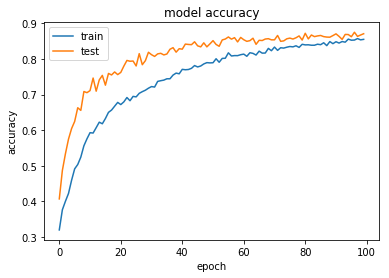

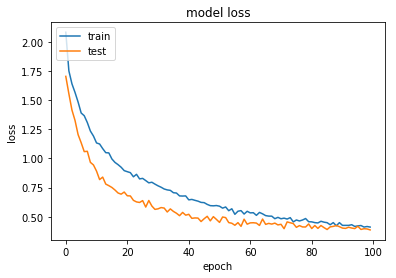

In [61]:

history = model.fit(np.array(XTrain), np.array(YTrain), batch_size=20, epochs=100, validation_data=(np.array(XTest), np.array(YTest)))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 100/100
7212/7212 [==============================] - 7s 940us/step - loss: 0.4106 - acc: 0.8551 - val_loss: 0.3862 - val_acc: 0.8709

In [21]:
del XTrain, XTest, mfccs_40

NameError: name 'X' is not defined

In [22]:
gtcc_vectors = pickle.load( open( "GTCCs.txt", "rb" ) )

gtcc_vectors[0].shape

(64, 399)

In [23]:
X = np.empty((filepaths.shape[0],64,399), object)

In [24]:
for i in range (filepaths.shape[0]):
    if gtcc_vectors[i].shape == (64,403):
        gtcc_vectors[i] = gtcc_vectors[i][:,:399]
    X[i] = gtcc_vectors[i]
X.shape
#X.shape

(10303, 64, 399)

In [25]:
del gtcc_vectors

In [26]:
from sklearn.model_selection import train_test_split
XTrain,XTest,YTrain,YTest=train_test_split(X,labels,test_size=0.3)

from keras.utils import to_categorical

YTrain = to_categorical(YTrain, num_classes=12)
YTest = to_categorical(YTest, num_classes=12)

del X

In [27]:
XTrain = XTrain.reshape(XTrain.shape[0], 64, 399, 1)
XTest = XTest.reshape(XTest.shape[0], 64, 399, 1)

np.savez('data_h.npz', XTrain=XTrain, XTest=XTest, YTrain=YTrain, YTest=YTest)
print(XTrain.shape)
print(XTest.shape)

(7212, 64, 399, 1)
(3091, 64, 399, 1)


In [29]:
model2 = Sequential()

model2.add(Conv2D(16, kernel_size=(2, 2), activation='relu', input_shape=(64, 399, 1), padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.50))

model2.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'))
#model.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.50))
model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.50))

model2.add(Dense(12, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [30]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 399, 16)       80        
_________________________________________________________________
batch_normalization_3 (Batch (None, 64, 399, 16)       64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 199, 16)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32, 199, 16)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 199, 32)       2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 99, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 99, 32)        0         
__________

Train on 7212 samples, validate on 3091 samples
Epoch 1/50
7212/7212 [==============================] - 23s 3ms/step - loss: 4.9706 - acc: 0.2507 - val_loss: 2.0534 - val_acc: 0.3387
Epoch 2/50
7212/7212 [==============================] - 21s 3ms/step - loss: 1.8241 - acc: 0.3496 - val_loss: 1.8927 - val_acc: 0.3335
Epoch 3/50
7212/7212 [==============================] - 21s 3ms/step - loss: 1.6739 - acc: 0.4028 - val_loss: 1.6633 - val_acc: 0.4419
Epoch 4/50
7212/7212 [==============================] - 21s 3ms/step - loss: 1.5837 - acc: 0.4391 - val_loss: 1.5575 - val_acc: 0.5099
Epoch 5/50
7212/7212 [==============================] - 21s 3ms/step - loss: 1.4937 - acc: 0.4616 - val_loss: 1.4267 - val_acc: 0.5700
Epoch 6/50
7212/7212 [==============================] - 21s 3ms/step - loss: 1.4383 - acc: 0.4749 - val_loss: 1.4499 - val_acc: 0.5675
Epoch 7/50
7212/7212 [==============================] - 21s 3ms/step - loss: 1.4142 - acc: 0.4806 - val_loss: 1.3428 - val_acc: 0.5713
Epoch 8

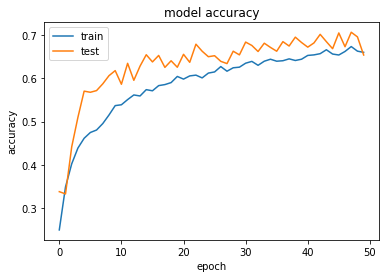

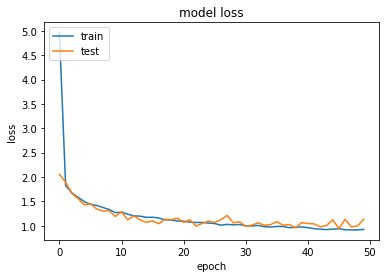

In [31]:
history = model2.fit(np.array(XTrain), np.array(YTrain), batch_size=20, epochs=50, validation_data=(np.array(XTest), np.array(YTest)))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 50/50
7212/7212 [==============================] - 22s 3ms/step - loss: 0.9229 - acc: 0.6593 - val_loss: 1.1340 - val_acc: 0.6532

In [33]:
model2.save("Experiments/GTCC_model.h5")

In [62]:
model.save("Experiments/MFCC_model.h5")

Usage of FC layers instead of CONV layers

In [50]:
model3 = Sequential()

model3.add(Dense(256, input_shape=(40,)))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(256))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

model3.add(Dense(12))
model3.add(Activation('softmax'))

model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [51]:
model3.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
activation_14 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
__________

In [42]:
X = np.empty((filepaths.shape[0],40), object)

for i in range (filepaths.shape[0]):
    X[i] = mfccs_40[i].mean(axis =1)
X.shape

(10303, 40)

In [44]:
X[0].shape

(40,)

In [47]:
from sklearn.model_selection import train_test_split
XTrain,XTest,YTrain,YTest=train_test_split(X,labels,test_size=0.3)

from keras.utils import to_categorical

YTrain = to_categorical(YTrain, num_classes=12)
YTest = to_categorical(YTest, num_classes=12)

del X

Train on 7212 samples, validate on 3091 samples
Epoch 1/100
7212/7212 [==============================] - 4s 492us/step - loss: 10.6375 - acc: 0.2672 - val_loss: 4.4467 - val_acc: 0.4950
Epoch 2/100
7212/7212 [==============================] - 3s 421us/step - loss: 3.1708 - acc: 0.4009 - val_loss: 1.5403 - val_acc: 0.5568
Epoch 3/100
7212/7212 [==============================] - 3s 416us/step - loss: 1.6139 - acc: 0.4691 - val_loss: 1.2751 - val_acc: 0.6021
Epoch 4/100
7212/7212 [==============================] - 3s 408us/step - loss: 1.3723 - acc: 0.5338 - val_loss: 1.1097 - val_acc: 0.6694
Epoch 5/100
7212/7212 [==============================] - 3s 411us/step - loss: 1.2695 - acc: 0.5736 - val_loss: 0.9924 - val_acc: 0.6842
Epoch 6/100
7212/7212 [==============================] - 3s 418us/step - loss: 1.1906 - acc: 0.6007 - val_loss: 0.9200 - val_acc: 0.7156
Epoch 7/100
7212/7212 [==============================] - 3s 429us/step - loss: 1.1035 - acc: 0.6256 - val_loss: 0.8736 - val_acc:

7212/7212 [==============================] - 3s 428us/step - loss: 0.6120 - acc: 0.8057 - val_loss: 0.4507 - val_acc: 0.8644
Epoch 61/100
7212/7212 [==============================] - 3s 420us/step - loss: 0.6124 - acc: 0.8109 - val_loss: 0.4410 - val_acc: 0.8690
Epoch 62/100
7212/7212 [==============================] - 3s 457us/step - loss: 0.6289 - acc: 0.7981 - val_loss: 0.4634 - val_acc: 0.8622
Epoch 63/100
7212/7212 [==============================] - 3s 470us/step - loss: 0.6123 - acc: 0.8012 - val_loss: 0.4223 - val_acc: 0.8664
Epoch 64/100
7212/7212 [==============================] - 4s 500us/step - loss: 0.6225 - acc: 0.7991 - val_loss: 0.4345 - val_acc: 0.8654
Epoch 65/100
7212/7212 [==============================] - 3s 449us/step - loss: 0.6124 - acc: 0.8028 - val_loss: 0.4364 - val_acc: 0.8670
Epoch 66/100
7212/7212 [==============================] - 3s 450us/step - loss: 0.6151 - acc: 0.8012 - val_loss: 0.4432 - val_acc: 0.8619
Epoch 67/100
7212/7212 [=======================

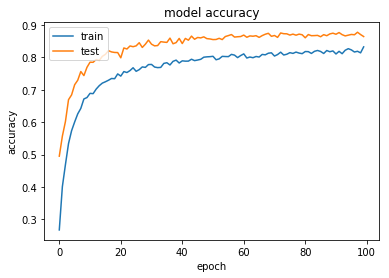

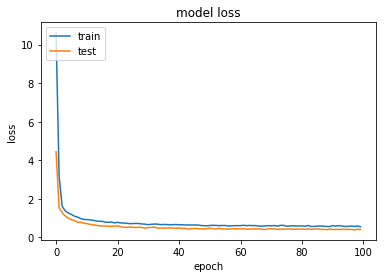

In [52]:
history = model3.fit(np.array(XTrain), np.array(YTrain), batch_size=20, epochs=100, validation_data=(np.array(XTest), np.array(YTest)))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
model3.save("Experiments/FC_model.h5")

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Test Set Metrics
Y_test = np.argmax(YTest, axis=1) # Convert one-hot to index
y_pred = model2.predict_classes(XTest)
print(classification_report(Y_test, y_pred))
print(confusion_matrix(Y_test, y_pred))

             precision    recall  f1-score   support

          0       0.40      0.88      0.55       306
          1       1.00      0.19      0.32        57
          2       0.43      0.41      0.42       298
          3       0.72      0.17      0.28       194
          4       0.51      0.41      0.45       248
          5       0.72      0.74      0.73       280
          6       0.00      0.00      0.00         8
          7       0.48      0.59      0.53       234
          8       0.85      0.70      0.76       258
          9       0.54      0.50      0.52       300
         10       0.99      0.79      0.88       461
         11       0.99      0.99      0.99       447

avg / total       0.70      0.65      0.65      3091

[[269   0   0   0   4  16   0   8   0   6   0   3]
 [  2  11  16   0   3   0   0   5   0  20   0   0]
 [ 70   0 122   4   6  22   0  22   5  46   1   0]
 [ 30   0  55  33  10  11   0  24  11  18   2   0]
 [ 53   0  11   1 101  10   0  59   1  12   0   0]


d:\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
Y_train = np.argmax(YTrain, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(XTrain)
print(classification_report(Y_train, y_pred))

             precision    recall  f1-score   support

          0       0.82      0.97      0.89       805
          1       1.00      0.89      0.94       168
          2       0.89      0.91      0.90       786
          3       1.00      0.80      0.89       537
          4       0.93      0.92      0.92       648
          5       0.97      0.94      0.95       759
          6       1.00      1.00      1.00        14
          7       0.91      0.95      0.93       637
          8       0.99      0.96      0.98       719
          9       0.93      0.92      0.93       816
         10       1.00      0.99      1.00      1154
         11       1.00      1.00      1.00      1199

avg / total       0.95      0.94      0.94      8242



Interpretation 

             precision    recall  f1-score   support

          0       0.40      0.88      0.55       306
          1       1.00      0.19      0.32        57
          2       0.43      0.41      0.42       298
          3       0.72      0.17      0.28       194
          4       0.51      0.41      0.45       248
          5       0.72      0.74      0.73       280
          6       0.00      0.00      0.00         8
          7       0.48      0.59      0.53       234
          8       0.85      0.70      0.76       258
          9       0.54      0.50      0.52       300
         10       0.99      0.79      0.88       461
         11       0.99      0.99      0.99       447

avg / total       0.70      0.65      0.65      3091

Confusion matrix, without normalization
[[269   0   0   0   4  16   0   8   0   6   0   3]
 [  2  11  16   0   3   0   0   5   0  20   0   0]
 [ 70   0 122   4   6  22   0  22   5  46   1   0]
 [ 30   0  55  33  10  11   0  24  11  18   2   0]
 [ 53   0  

d:\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


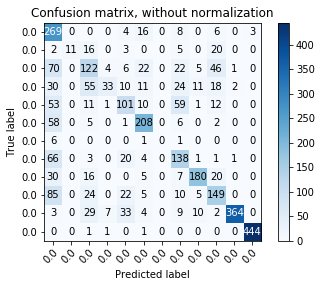

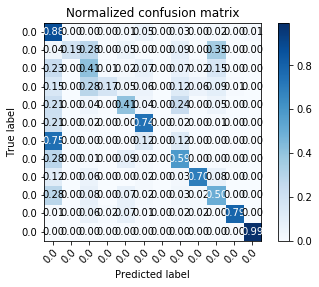

In [40]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
y_test = np.argmax(YTest, axis=1)
y_pred = model2.predict_classes(XTest)
print(classification_report(Y_test, y_pred))
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

### Experiment3: Grid Search Routine

- Varying dropout probabilities, sampling from a uniform distribution
- Different layer output sizes
- Different optimization algorithms to use
- Varying choices of activation functions
- Conditionally adding layers depending on a choice
- Swapping whole sets of layers

In [21]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [22]:
def data():
    data = np.load('data_h.npz')
    X_train = np.asarray(data['XTrain'])
    X_test = np.asarray(data['XTest'])
    Y_train = np.asarray(data['YTrain'])
    Y_test = np.asarray(data['YTrain'])

    return X_train, Y_train, X_test, Y_test


Your data function needs to return the values in exactly this order: X_train, Y_train, X_test, Y_test. Be careful if you’re using scikit learns train_test_split, as this returns the values in a different order

The Model Function is where you define your model. You can use your all available keras functions and layers. To add Hyperparameters for tuning, you can use the {{uniform()}} and {{choice()}} keywords. <br>
In the above example, let's say we want to optimize for the best dropout probability in both dropout layers. Choosing a uniform distribution over the interval [0,1], this translates into the following definition. Note that before returning the model, to optimize, we also have to define which evaluation metric of the model is important to us. For example, in the following, we optimize for accuracy.

## Experiment : Try GTCC model

## Experiment : Try different MFCC filters

## Experiment : SVM Classifier

In [15]:
X = np.empty((filepaths.shape[0],40), object)

for i in range (filepaths.shape[0]):
    X[i] = mfccs_40[i].mean(axis =1)
X.shape

(10303, 40)

In [16]:
from sklearn.model_selection import train_test_split
XTrain,XTest,YTrain,YTest=train_test_split(X,labels,test_size=0.3)

from keras.utils import to_categorical

#YTrain = to_categorical(YTrain, num_classes=12)
#YTest = to_categorical(YTest, num_classes=12)

del X

In [21]:
import numpy as np
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Load data from numpy file
#X =  np.load('feat.npy')
#y =  np.load('label.npy').ravel()

# Split data into training and test subsets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Simple SVM


In [22]:
print('fitting...')
clf = SVC(C=20.0, gamma=0.00001)
clf.fit(XTrain, YTrain)
acc = clf.score(XTest, YTest)
print("acc=%0.3f" % acc)

fitting...
acc=0.830


In [ ]:
#Grid search for best parameters
#Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5],
                     'C': [1, 10 ,20,30,40,50]}]
                    #  ,
                    # {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print('')

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print('')
    print(clf.best_params_)
    print('')
    print("Grid scores on development set:")
    print('')
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print('')

    print("Detailed classification report:")
    print('')
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print('')
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print('')

## Experiment : Grid Search CONV NET

In [7]:
mfcc_vectors = pickle.load( open( "MFCCs.txt", "rb" ) )
mfcc_vectors.shape

(10303, 11)

In [10]:
mfccs_80 = mfcc_vectors[:,6]
#del mfcc_vectors
mfccs_80[0].shape

(80, 87)

In [11]:
X = np.empty((filepaths.shape[0],80,87), object)

In [12]:
for i in range (filepaths.shape[0]):
    X[i] = mfccs_80[i]
X.shape

(10303, 80, 87)

In [13]:
from sklearn.model_selection import train_test_split
XTrain,XTest,YTrain,YTest=train_test_split(X,labels,test_size=0.3)

from keras.utils import to_categorical

YTrain = to_categorical(YTrain, num_classes=12)
YTest = to_categorical(YTest, num_classes=12)

del X

d:\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [15]:
XTrain = XTrain.reshape(XTrain.shape[0], 80, 87, 1)
XTest = XTest.reshape(XTest.shape[0], 80, 87, 1)

np.savez('data_h.npz', XTrain=XTrain, XTest=XTest, YTrain=YTrain, YTest=YTest)
print(XTrain.shape)
print(XTest.shape)
x = np.concatenate((XTrain,XTest), axis=0)

y = np.concatenate((YTrain,YTest), axis=0)
y.shape

(7212, 80, 87, 1)
(3091, 80, 87, 1)


(10303, 12)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Activation

def model4(x_train, y_train, x_val, y_val, params):
    conv_dropout = float(params['conv_dropout'])
    dense1_neuron = int(params['dense1_neuron'])
    model = Sequential()
    model.add(BatchNormalization(input_shape=(80, 87, 1)))
    model.add(Conv2D(16, (2, 2), padding='same', activation=params['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(conv_dropout))

    model.add(BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(Conv2D(32, (2, 2), padding='same', activation=params['activation']))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(conv_dropout))


    model.add(Flatten())
    model.add(Dense(dense1_neuron))
    model.add(Activation(params['activation']))
    model.add(Dropout(0.5))
    model.add(Dense(12))
    model.add(Activation('softmax'))
  
    model.compile(
        optimizer='adam', # tf.train.AdamOptimizer(learning_rate=1e-3, )
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


    out = model.fit(
        x, y, epochs=10, batch_size=32, 
        verbose=0,
        validation_data=[x_val, y_val]
    )
    return out, model

In [17]:
import talos as ta

para = {
    'dense1_neuron': [64, 128, 256],
    'activation': ['relu', 'elu'],
    'conv_dropout': [0.25, 0.4, 0.5]
}

In [18]:
scan_results = ta.Scan(x, y, para, model4)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [25:56<00:00, 85.01s/it]


In [20]:
scan_results.data

,round_epochs,val_loss,val_acc,loss,acc,dense1_neuron,activation,conv_dropout
0,10,0.045400,0.987059,0.168463,0.940891,128,elu,0.25
1,10,0.282217,0.917826,0.309076,0.896341,128,elu,0.50
2,10,0.159936,0.944678,0.260515,0.909832,64,elu,0.25
3,10,0.951354,0.725655,1.305312,0.495972,128,relu,0.50
4,10,0.390346,0.884180,0.362808,0.877803,64,elu,0.40
5,10,1.446993,0.505662,1.726059,0.344172,64,relu,0.50
6,10,0.522326,0.849240,0.831271,0.700767,256,relu,0.50
7,10,0.447528,0.895827,0.221041,0.925944,256,elu,0.50
8,10,0.282178,0.918149,0.555608,0.804426,256,relu,0.25
9,10,0.466893,0.862181,0.446944,0.847617,64,elu,0.50
